# Predicting daily bikerider count from temperature and weekday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn
import sklearn.gaussian_process as gp

# import custom functions for data loading and plotting
import sys  
sys.path.insert(0, './../modules')
import m_data_loading as mdl
import m_plotting as mplot

## Import data

We import a dataset that contains the daily number of bike riders at a counting station in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.') in 2021 as well as the daily average temperature and a boolean whether a given day is a business day.

In [2]:
# counting station and time period
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2021, 12, 31)

# import data
combined_daily_dat = mdl.get_data_for_location(city_name, counter_site, channel_name, start_date, end_date)

# sort by temperature
combined_daily_dat.sort_values(by=['temperature'], inplace=True)

In [3]:
# inspect
combined_daily_dat

,standort,counter_site,channel_name,longitude,latitude,date,temperature,is_busday,rider_count
40,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-02-11,-6.9,True,627
39,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-02-10,-6.4,True,774
41,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-02-12,-5.8,True,1025
15,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-16,-5.6,False,421
42,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-02-13,-5.2,False,1221
...,...,...,...,...,...,...,...,...,...
217,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-08-13,23.3,True,4408
218,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-08-14,23.4,False,3280
163,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-06-18,24.2,True,5867
164,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-06-19,24.4,False,4294


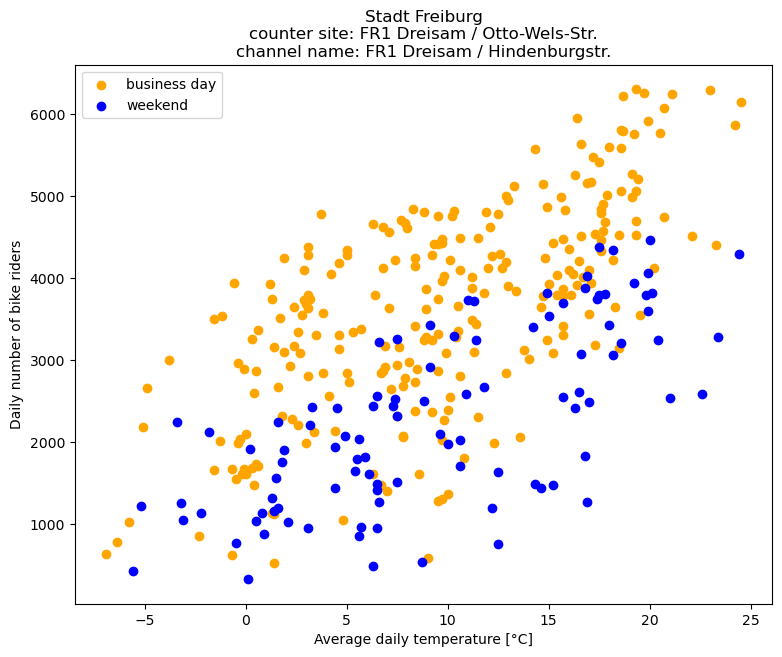

In [4]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.figure(figsize=(9,7))
plt.title(city_name + '\ncounter site: ' + counter_site + '\nchannel name: ' + channel_name);
mplot.plot_data()

## Gaussian process regression

Following https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 and https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

### Use temperature as predictor

In [5]:
# extract temperatures as x and rider counts as y
X_train = combined_daily_dat['temperature'].values.reshape(-1, 1)
y_train = combined_daily_dat['rider_count'].values.reshape(-1, 1)

In [6]:
# fit Gaussian process

kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.4, normalize_y=True)
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.4, kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=True)

In [7]:
# extract parameters
params = model.kernel_.get_params()
params

{'k1': 2.81**2,
 'k2': RBF(length_scale=48.9),
 'k1__constant_value': 7.880210266295214,
 'k1__constant_value_bounds': (0.1, 1000.0),
 'k2__length_scale': 48.90709079674755,
 'k2__length_scale_bounds': (0.001, 1000.0)}

Use kernel to compute the mean prediction and plot 95% confidence interval

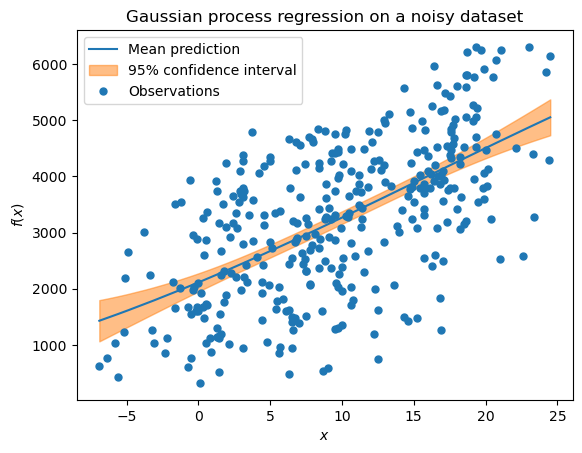

In [8]:
mean_prediction, std_prediction = model.predict(X_train, return_std=True)

plt.errorbar(
    X_train,
    y_train,
    #noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X_train, mean_prediction, label="Mean prediction")
plt.fill_between(
    X_train.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [9]:
# median absolute error between mean prediction and observed datapoints
sklearn.metrics.median_absolute_error(y_train, mean_prediction)

770.1181544304991

### Use temperature and is_busday as predictor

In [10]:
# extract temperatures and weekday information as X and rider counts as y
X_train = combined_daily_dat[['temperature', 'is_busday']].values.reshape(-1, 2)
y_train = combined_daily_dat['rider_count'].values.reshape(-1, 1)

In [11]:
# fit Gaussian process
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(np.array([10.0, 10.0]), (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.3, normalize_y=True)
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.3, kernel=1**2 * RBF(length_scale=[10, 10]),
                         n_restarts_optimizer=10, normalize_y=True)

In [12]:
# extract parameters
params = model.kernel_.get_params()
params

{'k1': 1.08**2,
 'k2': RBF(length_scale=[9.73, 1.11]),
 'k1__constant_value': 1.1708160264928376,
 'k1__constant_value_bounds': (0.1, 1000.0),
 'k2__length_scale': array([9.72887281, 1.11009961]),
 'k2__length_scale_bounds': (0.001, 1000.0)}

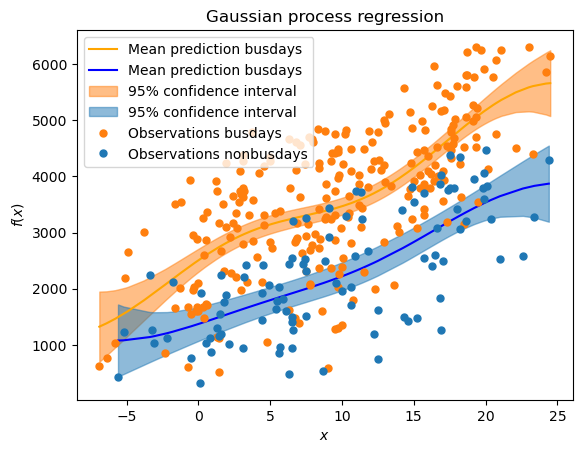

In [13]:
mean_prediction, std_prediction = model.predict(X_train, return_std=True)


# indices business days
indices_business_days = []

for idx, elem in enumerate(X_train):
    if (elem[1]):
        indices_business_days.append(idx)
indices_business_days

indices_nonbusdays = np.setdiff1d(np.arange(len(X_train)), indices_business_days)


plt.errorbar(
    X_train[indices_business_days,0],
    y_train[indices_business_days],
    #noise_std,
    linestyle="None",
    color="tab:orange",
    marker=".",
    markersize=10,
    label="Observations busdays",
)
plt.errorbar(
    X_train[indices_nonbusdays,0],
    y_train[indices_nonbusdays],
    #noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations nonbusdays",
)

plt.plot(X_train[indices_business_days, 0], mean_prediction[indices_business_days], label="Mean prediction busdays", color='orange')
plt.plot(X_train[indices_nonbusdays, 0], mean_prediction[indices_nonbusdays], label="Mean prediction busdays", color='blue')

plt.fill_between(
    np.array(X_train[indices_business_days,0],dtype=float).ravel(),
    mean_prediction[indices_business_days] - 1.96 * std_prediction[indices_business_days],
    mean_prediction[indices_business_days] + 1.96 * std_prediction[indices_business_days],
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.fill_between(
    np.array(X_train[indices_nonbusdays,0],dtype=float).ravel(),
    mean_prediction[indices_nonbusdays] - 1.96 * std_prediction[indices_nonbusdays],
    mean_prediction[indices_nonbusdays] + 1.96 * std_prediction[indices_nonbusdays],
    color="tab:blue",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression")

In [14]:
# median absolute error between mean prediction and observed datapoints
sklearn.metrics.median_absolute_error(y_train, mean_prediction)

637.5081025474947